In [1]:
import time
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg


In [2]:
# import data
client = MongoClient(host="localhost", port=27017)
db = client ["air-quality"]
dar = db["dar-es-salaam"]

In [ ]:
sites = dar.distinct("metadata.site")
sites

readings_per_site = list(dar.aggregate(
    [
       {"$group": {"_id":"$metadata.site","count":{"$count":{}}}} 
    ]
))

readings_per_site

In [ ]:
def wrangle(collection):
    results = collection.find(
        {"metadata.site": 11, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )

    df = pd.DataFrame(results).set_index("timestamp")
    
    #Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")
    
    #Remove outliers
    df = df[df["P2"] < 100]
    
    # Resample 1H window and ffill missing values    
    y = df["P2"].resample("1H").mean().fillna(method="ffill")
    
    
    return y

In [ ]:
y = wrangle(dar)
y.head()

In [ ]:
# time series plot of reading in y
fig, ax = plt.subplots(figsize=(15, 6))
y["P2"].plot(xlabel="Date", ylabel="PM2.5 Level", title="Dar es Salaam PM2.5 Levels", ax= ax);
plt.savefig("images/3-5-5.png", dpi=150)


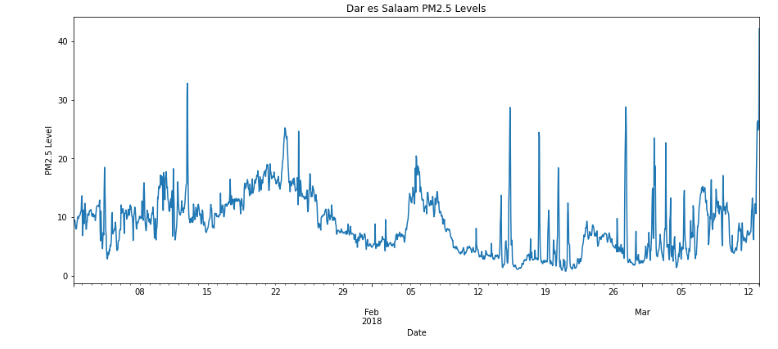

In [ ]:
#  Rolling average plot of the reading of y
fig, ax = plt.subplots(figsize=(15, 6))
y["P2"].rolling(168).mean().plot(ax=ax, xlabel="Date", ylabel="PM2.5 Level", title="Dar es Salaam PM2.5 Levels, 7-Day Rolling Average");
plt.savefig("images/3-5-6.png", dpi=150)

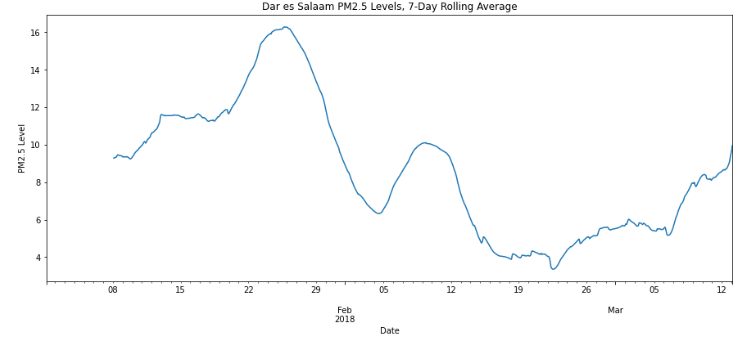

In [ ]:
# ACF plot for the data in y
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, ACF");
plt.savefig("images/3-5-7.png", dpi=150)


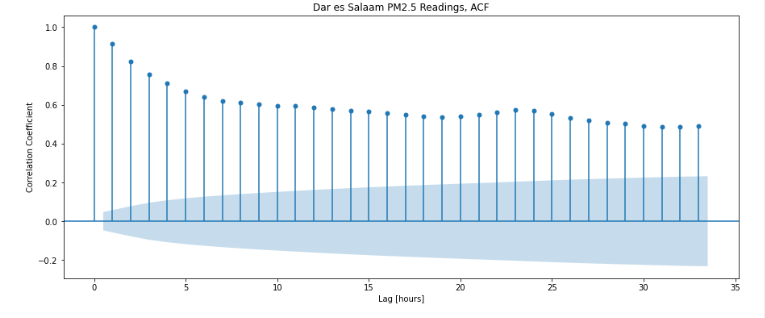

In [ ]:
# PACF plot for the data in y
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, ACF");
plt.savefig("images/3-5-8.png", dpi=150)


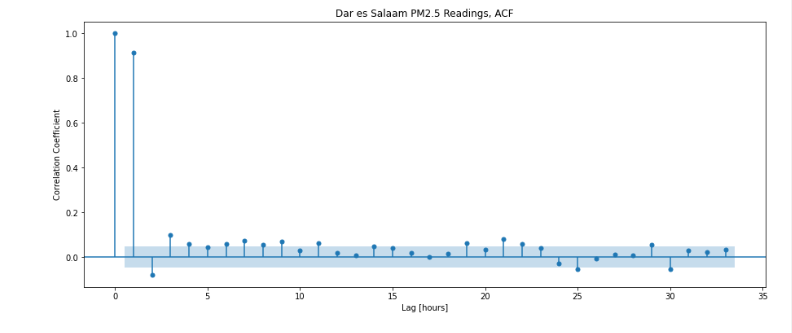

In [ ]:
#  Split y into training and test sets
cutoff_test = int(len(y)* 0.9)
y_train =y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
y_train.astype
y_test.astype

In [ ]:
# Baseline mean absolute error for your model
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len (y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

In [ ]:
# use an AR model to predict PM2.5 readings using settings for p from 1 to 30

p_params = range(1, 31)
maes = []

for p in p_params:
    
    start_time = time.time()
    
    elapsed_time = round(time.time() - start_time, 2)
    

    model = AutoReg(y_train,lags=p).fit()

    elaps_time = round(time.time()-start_time,3)


    print(f"Trained AutoReg model {p} in {elaps_time} secondes")

    y_pred = model.predict().dropna()
    

    
    mea = mean_absolute_error(y_train.iloc[p:], y_pred)


#Append the means in the list
    maes.append(mea)
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head(31)


In [ ]:
# Build and train final_model using the best hyperparameter value

best_p = 28
best_model = AutoReg(y_train,lags=28).fit()

In [ ]:
# Calculate the training residuals for best_model 
y_train_resid = model.resid 
y_train_resid.name = "residuals"
y_train_resid.head()

In [ ]:
# Plot histogram of residuals
y_train_resid.hist()
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Best Model, Training Residuals");
plt.savefig("images/3-5-14.png", dpi=150)

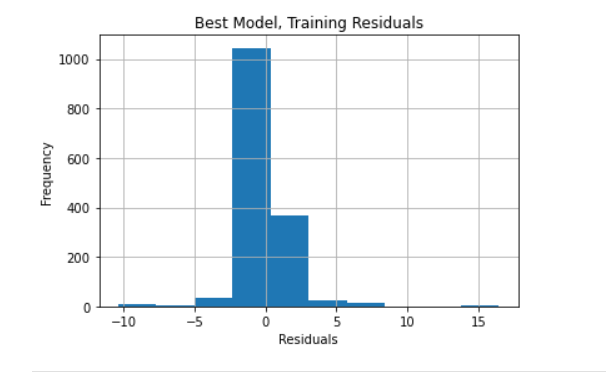

In [ ]:
# An ACF plot for y_train_resid
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, ACF")
# Don't delete the code below 👇
plt.savefig("images/3-5-15.png", dpi=150)

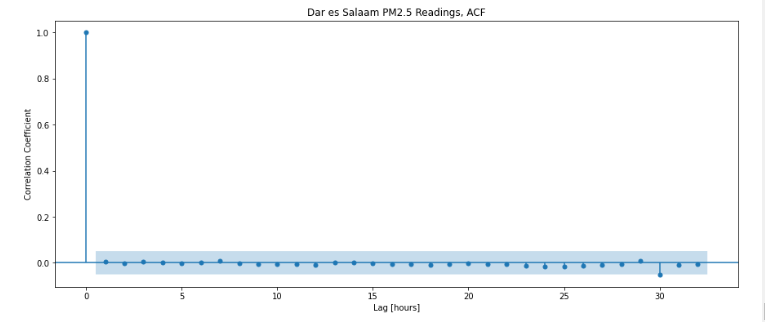

In [ ]:
# plot_diagnostics method to check the residuals for model
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig)

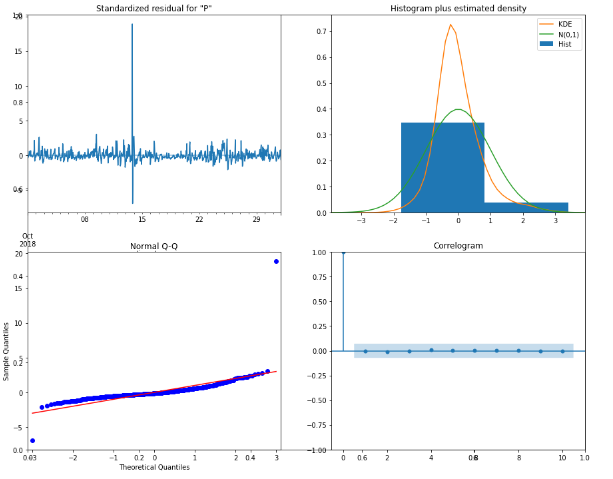

In [ ]:
#  Perform walk-forward validation for model 
y_pred_wfv = pd.Series()
history =  y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=30).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
    pass
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

In [ ]:
# communication the results
df_pred_test =pd.DataFrame(
    {"y_test": y_test, "y_pred_wfv": y_pred_wfv}
)
fig = px.line(df_pred_test , labels={"value": "PM2.5"})
fig.update_layout(
    title="Dar es Salaam, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)
fig.write_image("images/3-5-18.png", scale=1, height=500, width=700)

fig.show()

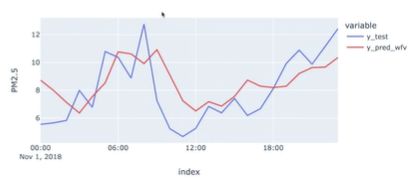